In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data.metrics import get_metrics

In [51]:
df = pd.read_json("../reports/discretization_tune_grid_cat.jsonl", lines=True)
df = df[df['grow_factor'] < 5]
get_metrics(df, ['top_1_accuracy', "top_5_accuracy", 'macro_f1'])

In [45]:
hparams = ["model_cls", "loc_levels", "grow_factor", "discretization_rows", 'discretization_shape']
metrics = [

    "macro_f1",
    "top_5_accuracy",
    "top_1_accuracy",
]

In [8]:
def make_discretization_row_plot(
    df, model, metric, df_base=None, ax=None, figsize=(6, 3)
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, sharex=True, sharey=True)
    if df_base is not None: 
        df = pd.concat([df, df_base[df_base['loc_levels'] == 1]])
    df_agg = (
        df.groupby(["discretization_rows", "loc_levels", "model_cls"])[metric]
        .agg(["mean", "std"])
        .reset_index()
    )
    df_model = df_agg[df_agg["model_cls"] == model]

    # Generate colors from the viridis colormap
    cmap = plt.get_cmap("viridis", 4)
    colors = cmap(range(4))

    x = np.arange(100, 501, 100)
    df_base = df_model[df_model['loc_levels'] == 1]
    y = df_base["mean"].item()
    err = df_base["std"]
    color = colors[0]
    ax.plot(x, np.ones_like(x) * y, color=color, label=1)
    ax.fill_between(x, y - err, y + err, alpha=0.2, color=color)

    for loc_level in range(2, 5):
        df_line = df_model[df_model["loc_levels"] == loc_level]
        x = df_line["discretization_rows"]
        y = df_line["mean"]
        err = df_line["std"]
        color = colors[loc_level - 1]
        ax.plot(x, y, label=loc_level, color=color)
        ax.fill_between(x, y - err, y + err, alpha=0.2, color=color)
    ax.set_xlim(100, 500)
    return ax

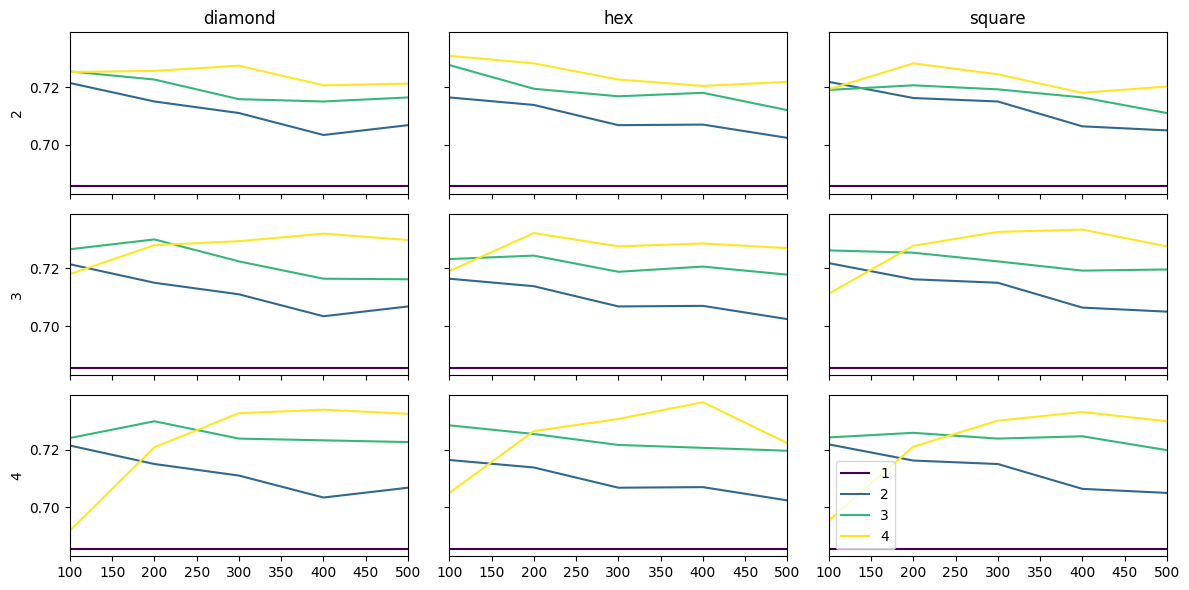

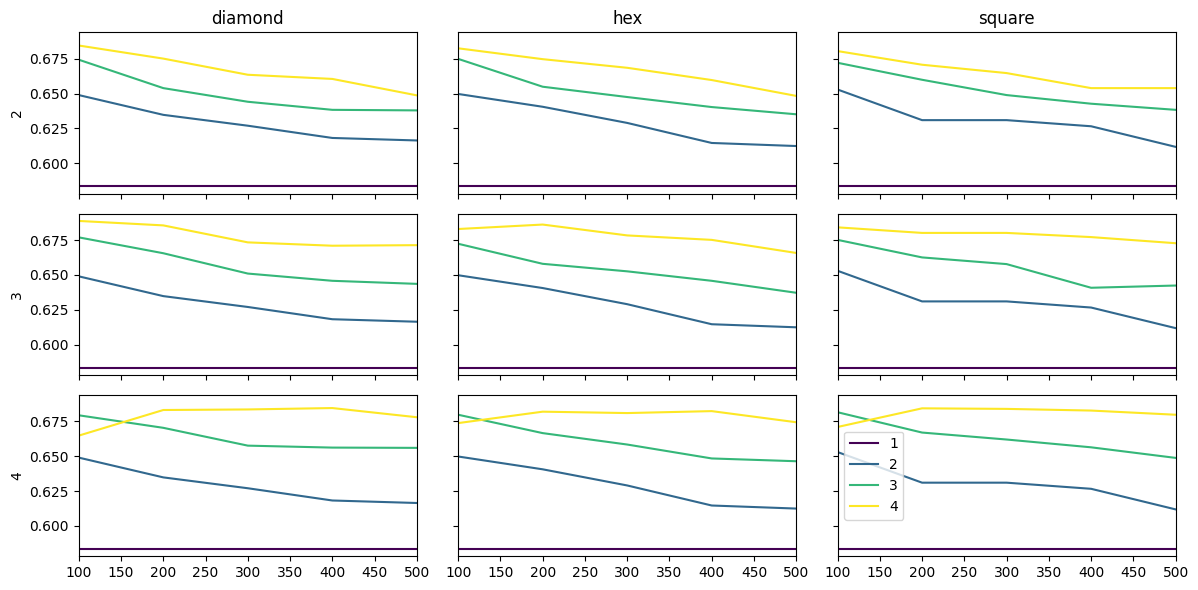

In [79]:
# Plot discretization shape + aggregation growth for BiTULER
metric = 'top_5_accuracy'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), sharex=True, sharey=True)
df_plot = df[df["aggregation_mode"] == "grow"]
for col_idx, (shape, df_col) in enumerate(df_plot.groupby("discretization_shape")):
    axs[0, col_idx].set_title(shape)
    for row_idx, (grow_factor, df_row) in enumerate(df_col.groupby("grow_factor")):
        ax = axs[row_idx, col_idx]
        make_discretization_row_plot(df_row, df_base=df, model='BiTULER', ax=ax, metric=metric)
        if col_idx == 0:
            ax.set_ylabel(grow_factor)
leg = ax.legend()
fig.tight_layout()

# Plot discretization shape + aggregation growth for BiTULER
metric = 'top_5_accuracy'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), sharex=True, sharey=True)
df_plot = df[df["aggregation_mode"] == "grow"]
for col_idx, (shape, df_col) in enumerate(df_plot.groupby("discretization_shape")):
    axs[0, col_idx].set_title(shape)
    for row_idx, (grow_factor, df_row) in enumerate(df_col.groupby("grow_factor")):
        ax = axs[row_idx, col_idx]
        make_discretization_row_plot(df_row, df_base=df, model='TULHOR', ax=ax, metric=metric)
        if col_idx == 0:
            ax.set_ylabel(grow_factor)
leg = ax.legend()
fig.tight_layout()

In [52]:
df["criterion"] = (
    2
    * df["top_1_accuracy"]
    * df["top_5_accuracy"]
    / (df["top_1_accuracy"] + df["top_5_accuracy"])
)
dfg = df[df["aggregation_mode"] == "grow"].reset_index()
df_mean = (
    dfg.groupby(
        ["loc_levels", "discretization_rows", "grow_factor"]
    )[metrics + ["criterion"]]
    .mean()
    .reset_index()
)
idcs_max = df_mean.groupby(["discretization_rows"])["top_5_accuracy"].idxmax()

df_mean.loc[idcs_max][
    ["loc_levels", "discretization_rows", "grow_factor"]
    + metrics
    + ["criterion"]
]

,loc_levels,discretization_rows,grow_factor,macro_f1,top_5_accuracy,top_1_accuracy,criterion
31,4,100,2,0.484184,0.7083,0.5412,0.613562
35,4,200,3,0.488040,0.7089,0.5491,0.618845
39,4,300,4,0.492399,0.7046,0.5473,0.616054
42,4,400,4,0.498451,0.7096,0.5543,0.622406
45,4,500,4,0.497132,0.6978,0.5553,0.618405


In [12]:
df_full = pd.read_json("../reports/discretization_grid_full.jsonl", lines=True)
# get_metrics(df_full, metrics=['top_1_accuracy', 'top_5_accuracy', 'macro_f1'])

In [13]:
df_grow = pd.read_json("../reports/discretization_grid_grow.jsonl", lines=True)
# get_metrics(df_grow, metrics=['top_1_accuracy', 'top_5_accuracy', 'macro_f1'])

In [14]:
df_cat = pd.read_json("../reports/discretization_grid_cat.jsonl", lines=True)
# get_metrics(df_cat, metrics=['top_1_accuracy', 'top_5_accuracy', 'macro_f1'])

In [15]:
df_sum = pd.read_json("../reports/discretization_grid_sum.jsonl", lines=True)
# get_metrics(df_sum, metrics=['top_1_accuracy', 'top_5_accuracy', 'macro_f1'])

In [16]:
df = pd.concat([df_full, df_grow, df_cat, df_sum])

In [17]:
get_metrics(df, metrics=['top_1_accuracy', 'top_5_accuracy', 'macro_f1'])

In [20]:
df.loc[df['loc_levels'] == 1, 'aggregation_mode'] = 'grow'

In [25]:
df.loc[(df['loc_levels'] == 2) & (df['model_cls'] == "TULHOR"), 'aggregation_mode'] = 'grow'

In [35]:
df.loc[
    (df["loc_levels"] == 2)
    & (df["embedding_type"].isin(["lookup_concat", "lookup_sum"])), 'aggregation_mode'
]  = 'grow'

In [39]:
df.to_json("../reports/discretization_grid.jsonl", orient='records', lines=True, index=False)

Text(0.5, 1.0, 'BiTULER')

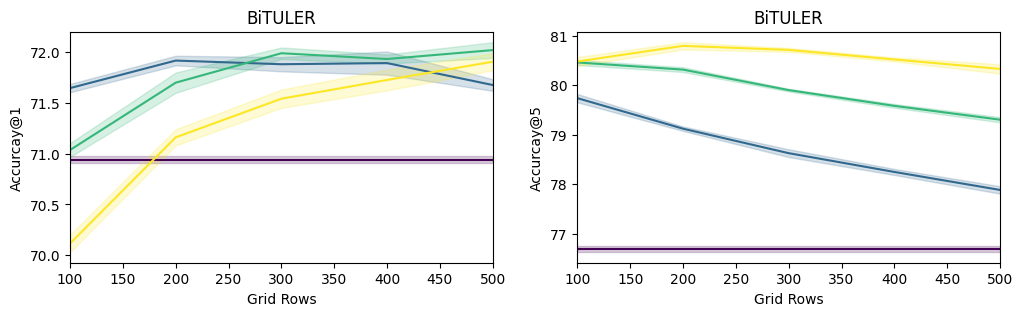

In [33]:
# Plot grouped discretization, weighted sum aggregation
df_plot = df[
    (df["embedding_type"] == "lookup_weighted_sum") & (df["aggregation_mode"] == "grow")
]
df_plot.loc[:, ["top_1_accuracy", 'top_5_accuracy']] *= 100
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)
make_discretization_row_plot(
    df_plot, model="BiTULER", metric="top_1_accuracy", ax=axs[0]
)
make_discretization_row_plot(
    df_plot, model="BiTULER", metric="top_5_accuracy", ax=axs[1]
)
axs[0].set_ylabel("Accurcay@1")
axs[1].set_ylabel("Accurcay@5")
axs[0].set_xlabel("Grid Rows")
axs[1].set_xlabel("Grid Rows")
axs[0].set_title("BiTULER")
axs[1].set_title("BiTULER")

Text(0.5, 1.0, 'TULHOR')

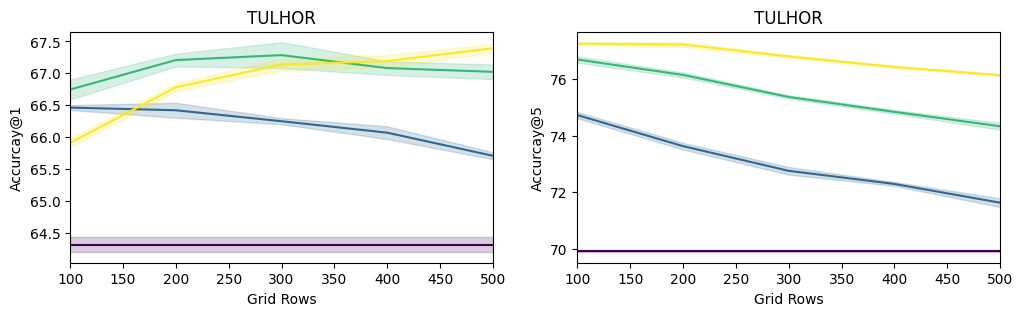

In [32]:
# Plot TULHOR Results
df_plot = df[
    (df["embedding_type"] == "lookup_weighted_sum") & (df["aggregation_mode"] == "grow")
]
df_plot.loc[:, ["top_1_accuracy", 'top_5_accuracy']] *= 100
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)
make_discretization_row_plot(
    df_plot, model="TULHOR", metric="top_1_accuracy", ax=axs[0]
)
make_discretization_row_plot(
    df_plot, model="TULHOR", metric="top_5_accuracy", ax=axs[1]
)
axs[0].set_ylabel("Accurcay@1")
axs[1].set_ylabel("Accurcay@5")
axs[0].set_xlabel("Grid Rows")
axs[1].set_xlabel("Grid Rows")
axs[0].set_title("TULHOR")
axs[1].set_title("TULHOR")

Text(0.5, 1.0, 'Weighted Sum')

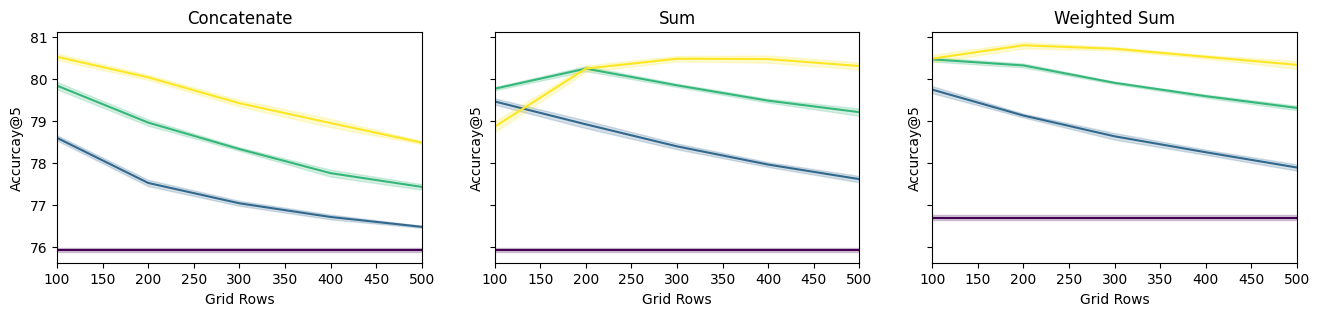

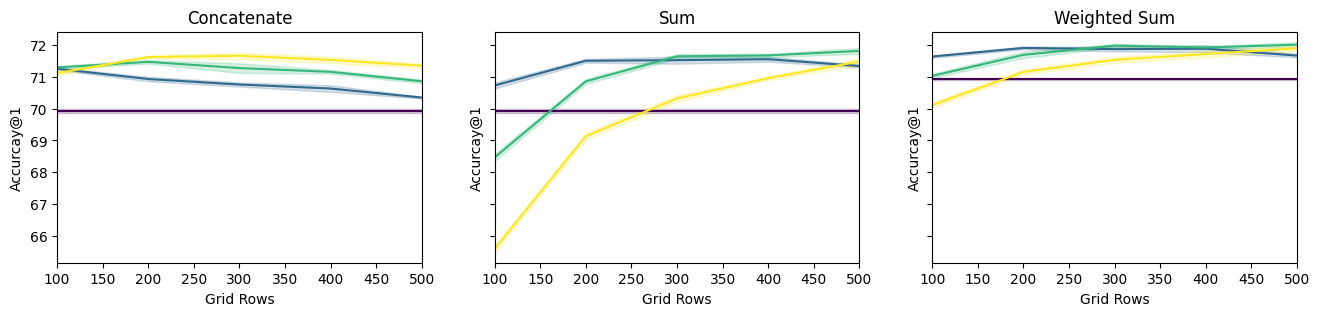

In [38]:
# Plot results for different embedding aggregation approaches
df_plot = df[(df["aggregation_mode"] == "grow")]
df_plot.loc[:, ["top_1_accuracy", "top_5_accuracy"]] *= 100

fig, axs = plt.subplots(ncols=3, figsize=(16, 3), sharex=True, sharey=True)
embedding_types = ["lookup_concat", "lookup_sum", "lookup_weighted_sum"]
for ax, embedding_type in zip(axs, embedding_types):
    df_type = df_plot[df_plot["embedding_type"] == embedding_type]
    make_discretization_row_plot(
        df_type,
        model="BiTULER",
        metric="top_5_accuracy",
        ax=ax,
    )
    ax.set_ylabel("Accurcay@5")
    ax.set_xlabel("Grid Rows")

axs[0].set_title("Concatenate")
axs[1].set_title("Sum")
axs[2].set_title("Weighted Sum")

df_plot = df[(df["aggregation_mode"] == "grow")]
df_plot.loc[:, ["top_1_accuracy", "top_5_accuracy"]] *= 100

fig, axs = plt.subplots(ncols=3, figsize=(16, 3), sharex=True, sharey=True)
embedding_types = ["lookup_concat", "lookup_sum", "lookup_weighted_sum"]
for ax, embedding_type in zip(axs, embedding_types):
    df_type = df_plot[df_plot["embedding_type"] == embedding_type]
    make_discretization_row_plot(
        df_type,
        model="BiTULER",
        metric="top_1_accuracy",
        ax=ax,
    )
    ax.set_ylabel("Accurcay@1")
    ax.set_xlabel("Grid Rows")

axs[0].set_title("Concatenate")
axs[1].set_title("Sum")
axs[2].set_title("Weighted Sum")

